#### Requirements

1. Librosa > ! pip install librosa

In [1]:
import librosa
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


In [2]:
# getting list of files in directory E:\\My_Projects\\ai_projects\\speech_emotion_recognizer\\Dataset\\Emo_DB\\wav
filepath = 'E:\\My_Projects\\ai_projects\\speech_emotion_recognizer\\Dataset\\Emo_DB\\wav'
file_list = os.listdir(filepath)

##### Audio File information

Every utterance is named according to the same scheme:<br><br>

Positions 1-2: number of speaker<br>
Positions 3-5: code for text<br>
Position 6: emotion (sorry, letter stands for german emotion word)<br>
Position 7: if there are more than two versions these are numbered a, b, c ....<br>
Example: 03a01Fa.wav is the audio file from Speaker 03 speaking text a01 with the emotion "Freude" (Happiness).<br>

Information about the speakers<br>
03 - male, 31 years old<br>
08 - female, 34 years<br>
09 - female, 21 years<br>
10 - male, 32 years<br>
11 - male, 26 years<br>
12 - male, 30 years<br>
13 - female, 32 years<br>
14 - female, 35 years<br>
15 - male, 25 years<br>
16 - female, 31 years<br>


Code of emotions:


|letter    |	emotion |(english) letter |emotion (german)|
|:--------:|:----------:|:---------------:|:--------------:|
|A	 |anger  |		W	|           	Ärger (Wut)|
|B	|boredom|		L	|  		Langeweile|
|D	|disgust|		E	|		Ekel|
|F	|anxiety/fear|	A	|		Angst|
|H	|happiness|	F		|	Freude|
|S	|sadness|		T	|		Trauer|
N = neutral version




##### an example file

In [3]:
file_list[0] ## a file name

'03a01Fa.wav'

 03a01Fa.wav is the audio file from Speaker 03 speaking text a01 with the emotion "Freude" (Happiness).

### All file dataframe

In [4]:
df = pd.DataFrame(zip(file_list,[re.findall(r'\w(?=\w\.)',x)[0] for x in file_list]),columns=['filename','Emotion'])

Text(0.5, 1.0, 'FRequency plot of emotions')

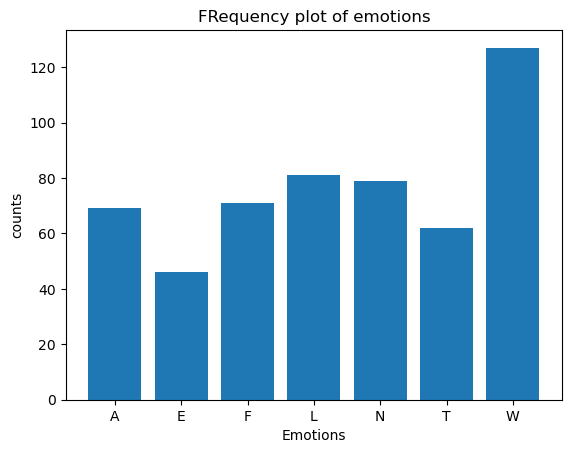

In [5]:
values, counts = np.unique(df['Emotion'], return_counts=True) ## Frequency plot of emotions 
plt.bar(values,counts)
plt.xlabel('Emotions')
plt.ylabel('counts')
plt.title('FRequency plot of emotions')

#### Getting information about wavefrom

In [6]:
## y-> waveform,  sr -> sample rate
y=[]
sr=[]
for file in file_list:
    yi, sri = librosa.load(filepath+'\\'+file)
    y.append(yi)
    sr.append(sri)
# y = np.asarray(y,dtype=object)
# sr = np.asarray(sr,dtype=object)
#print("shape for y",y.shape)

In [7]:
print("Sample rate is ",sr[445],"samples per second")

Sample rate is  22050 samples per second


## Explanatory Data Analysis

##### Audio data visualizations for audio file 03a01Fa.wav

In [8]:
emotions = ["Happiness(F)",
            "Neutral(N)",
            "Anger(W)",
            "Anxiety/Fear(A)",
            "Boredom(L)",
            "Disgust(T)",
            "Sadness(E)"]
emo_file_list = [0,1,2,8,10,5,310]

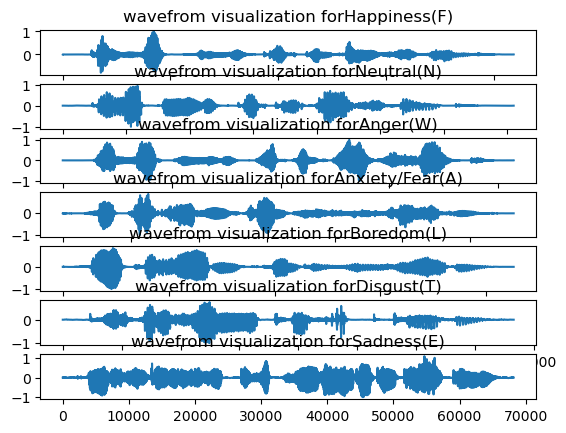

In [9]:
figure ,axes = plt.subplots(7)
for ind,val in enumerate(emo_file_list):    
    axes[ind].plot(range(0,y[val].shape[0]),y[val])
    axes[ind].set_title("wavefrom visualization for"+emotions[ind])
    


##### HPSS plot

what is harmonic sound?<br>

what is percusive sound?

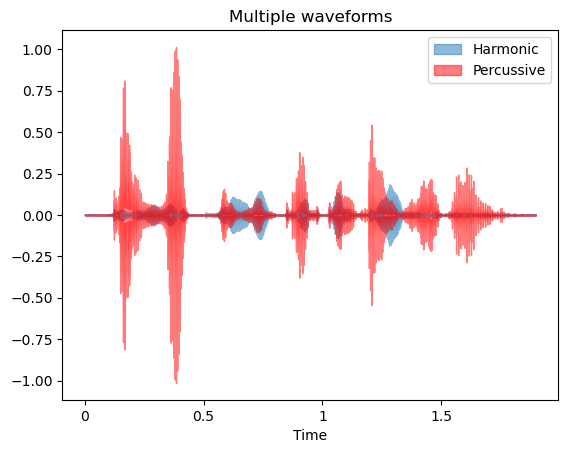

In [10]:
fig, ax = plt.subplots(sharex=True)
y_harm, y_perc = librosa.effects.hpss(y[0])
librosa.display.waveshow(y_harm, sr=sr[0], alpha=0.5, ax=ax, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr[0], color='r', alpha=0.5, ax=ax, label='Percussive')
ax.set(title='Multiple waveforms')
ax.legend()

In [11]:
df = pd.DataFrame(zip(file_list,[re.findall(r'\w(?=\w\.)',x)[0] for x in file_list],y,sr),columns=['filename','Emotion','waveform','sampling rate'])

#### Getting short time fourier transform(STFT)

The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.

In [12]:
stft = librosa.stft(y[0])
print(stft.shape)

(1025, 82)


##### Getting spectogram for audio instance 

C:\Users\cnctk\AppData\Local\Temp\ipykernel_15576\2446546785.py:1: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(stft)


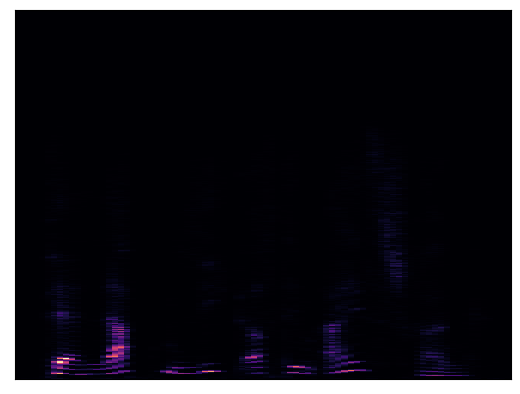

In [13]:
librosa.display.specshow(stft)

## Feature Extraction

1800 seconds * 8000hz = 14400000 samples <br>
hop length= it is no of samples a window is moved with each step.<br>
how many hops you can fit depends on whether you pad somehow or not<br>
if we decide not to pad the number of frames also depends on your window size.<br>

if we take how many samples are 10 ms?<br>
if 1 s = 8000 samples (i.e 8000hz)<br>
samples in 0.01s == 8000*0.01 = 80 samples <br>

i.e hop length of 80 samples and a window length of 160 samples (0.02s- twice as long)<br>

22050 samples in 1 s
smaples in 25ms = 22050*0.01

Here we are taking no. of frames as 25 ms 

In [15]:
### n_samples = frame_len*sample_rate
n_samples = 25 * 0.001 * sr[0]
print("no of samples",n_samples)

no of samples 551.25


#### Extracting MFCC features from 535 audio files

##### Grouping same emotions together

In [24]:
df_g = df.groupby(['Emotion'])

In [17]:
mfcc = []
for i in range(df.shape[0]):
     mfcc.append(librosa.feature.mfcc(y=y[i], sr=sr[i], hop_length=int(n_samples), n_mfcc=20))

In [18]:
mfcc[0].shape

(20, 76)

##### Plotting MFCC features and corresponding Spectograms

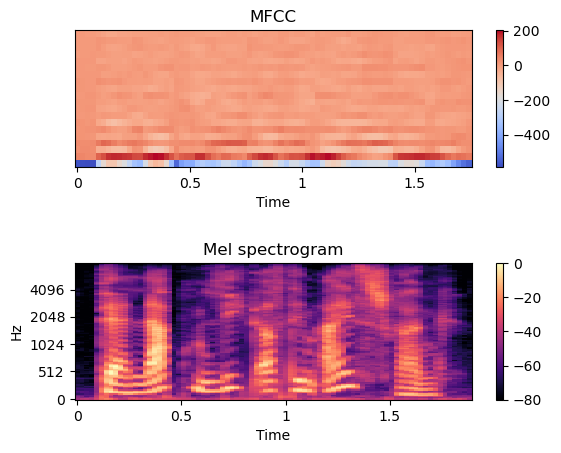

In [19]:
fig ,ax = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.7, wspace=0.5)

img = librosa.display.specshow(mfcc[0], x_axis='time', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='MFCC')

S = librosa.feature.melspectrogram(y=y[0], sr=sr[0], n_mels=128,fmax=8000)
mfcc_db = librosa.feature.mfcc(S=librosa.power_to_db(S))
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='Mel spectrogram')
ax[1].label_outer()

#### time domian features derived from mfcc features

###### Defining bin 

In [20]:
binsize = 4
mfcct =[]
for j in range(len(mfcc)):
    bins = mfcc[j].shape[0]/binsize  # no. of rows/binsize
    n_time_features = 12
    mfv = np.zeros((n_time_features*int(bins),mfcc[j].shape[1]))
    mfv.shape
    for k in range(mfcc[j].shape[1]):
        initial =1
        phai = 1
        for l in range(1,int(bins)+1):
            m = mfcc[j][initial-1:l*binsize,k]
            
            c = np.array([np.min(m),np.max(m),np.mean(m),int(stats.mode(m)[0]),np.median(m),np.var(m),
                          np.std(m),np.cov(m),np.sqrt(np.mean(m**2)),np.percentile(m,25),
                          np.percentile(m,50),np.percentile(m,75)])
        
            for p in range(12,0,-1):
                mfv[phai+n_time_features-p-1,k] = c[p-1]
                
            initial = initial+binsize
            phai = phai+n_time_features
    mfcct.append(mfv)
                

C:\Users\cnctk\AppData\Local\Temp\ipykernel_15576\1202758693.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  c = np.array([np.min(m),np.max(m),np.mean(m),int(stats.mode(m)[0]),np.median(m),np.var(m),


#### Creating Convolutional Model

In [21]:
mfcct[0].shape

(60, 76)